# **Predict Blood Donation for Future Expectancy**

Forecasting blood supply is a serious and recurrent problem for blood collection managers: in January 2019, "Nationwide, the Red Cross saw 27,000 fewer blood donations over the holidays than they see at other times of the year." Machine learning can be used to learn the patterns in the data to help to predict future blood donations and therefore save more lives.


# **Project Tasks**

* Inspecting transfusion.data file
* Loading the blood donations data
* Inspecting transfusion DataFrame
* Creating target column
* Checking target incidence
* Splitting transfusion into train and test datasets
* Selecting model using TPOT
* Checking the variance
* Log normalization
* Training the linear regression model
* Conclusion

## 1. Inspecting transfusion.data file
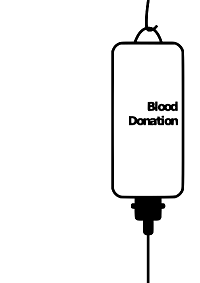
Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to WebMD "about 5 million Americans need a blood transfusion every year".


In [23]:
from google.colab import files
uploaded = files.upload()

Saving transfusion.data to transfusion (1).data


## 2. Loading the blood donations data


In [24]:
import pandas as pd
import numpy as np
transfusion = pd.read_csv('transfusion.data')
transfusion

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


## 3. Inspecting transfusion DataFrame
Let's briefly return to our discussion of RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

R (Recency - months since the last donation)

F (Frequency - total number of donation)

M (Monetary - total blood donated in c.c.)

T (Time - months since the first donation)

A binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)

It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.

In [25]:
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [26]:
transfusion.shape # To check number of rows and columns

(748, 5)

In [27]:
transfusion.isnull().sum() # To check null values

Recency (months)                              0
Frequency (times)                             0
Monetary (c.c. blood)                         0
Time (months)                                 0
whether he/she donated blood in March 2007    0
dtype: int64

In [28]:
transfusion.columns

Index(['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)',
       'Time (months)', 'whether he/she donated blood in March 2007'],
      dtype='object')

## 4. Creating target column
We are aiming to predict the value in whether he/she donated blood in March 2007 column.

Let's rename this it to target so that it's more convenient to work with.

In [29]:
transfusion.rename(columns={'whether he/she donated blood in March 2007': 'target'},inplace=True)
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 5. Checking target incidence
We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:</p>

0 - the donor will not give blood

1 - the donor will give blood

Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

In [30]:
transfusion.target.value_counts(normalize=True).round(2)

0    0.76
1    0.24
Name: target, dtype: float64

## 6. Splitting transfusion into train and test datasets

Target incidence informed us that in our dataset 0's appear 76% of the time and 1's appear 24 %. 

Now, We create a Train Test split and then move on to prediction.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    transfusion.drop(columns='target'),
    transfusion.target,
    test_size=0.25,
    random_state=42,
    stratify=transfusion.target
)

X_train.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
334,16,2,500,16
99,5,7,1750,26


## 7. Selecting model using TPOT
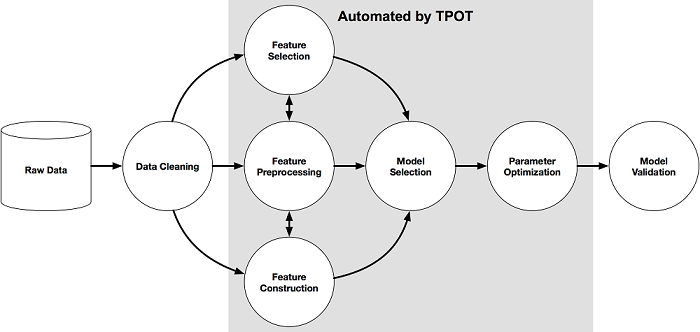

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming

TPOT will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a scikit-learn pipeline, meaning it will include any pre-processing steps as well as the model.

We are using TPOT to help us zero in on one model that we can then explore and optimize further.

In [32]:
!pip install TPOT

In [39]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    
    print(f'{idx}. {transform}')


Generation 1 - Current best internal CV score: 0.7422459184429089
Generation 2 - Current best internal CV score: 0.7422459184429089
Generation 3 - Current best internal CV score: 0.7422459184429089
Generation 4 - Current best internal CV score: 0.7422459184429089
Generation 5 - Current best internal CV score: 0.7423330644124079
Best pipeline: LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l2)

AUC score: 0.7853

Best pipeline steps:
1. LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## 8. Checking the variance
TPOT picked Logistic Regression as the best model for our dataset with no pre-processing steps, giving us the AUC score of 0.7853. This is a great starting point. Let's see if we can make it better.

One of the assumptions for linear regression models is that the data and the features we are giving it are related in a linear fashion, or can be measured with a linear distance metric. If a feature in our dataset has a high variance that's an order of magnitude or more greater than the other features, this could impact the model's ability to learn from other features in the dataset.

Correcting for high variance is called normalization. It is one of the possible transformations you do before training a model. Let's check the variance to see if such transformation is needed.

In [34]:
X_train.var().round(2)

Recency (months)              66.93
Frequency (times)             33.83
Monetary (c.c. blood)    2114363.70
Time (months)                611.15
dtype: float64

## 9. Log normalization
Monetary (c.c. blood)'s variance is very high in comparison to any other column in the dataset. This means that, unless accounted for, this feature may get more weight by the model (i.e., be seen as more important) than any other feature.

One way to correct for high variance is to use log normalization.

In [40]:
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()
col_to_normalize = 'Monetary (c.c. blood)'


for df_ in [X_train_normed, X_test_normed]:
    df_['Monetary_log'] = np.log(df_[col_to_normalize])
    df_.drop(columns=col_to_normalize, inplace=True)

X_train_normed.var().round(2)

Recency (months)      66.93
Frequency (times)     33.83
Time (months)        611.15
Monetary_log           0.84
dtype: float64

## 10. Training the linear regression model
The variance looks much better now. Notice that now Time (months) has the largest variance, but it's not the orders of magnitude higher than the rest of the variables, so we'll leave it as is.

We are now ready to train the linear regression model.

In [47]:
# Importing module
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=0.1, dual=False, penalty='l2',solver='liblinear',random_state=42)

# Train the model
logreg.fit(X_train_normed, y_train)


logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7868


## 11. Conclusion
The demand for blood fluctuates throughout the year. As one prominent example, blood donations slow down during busy holiday seasons. An accurate forecast for the future supply of blood allows for an appropriate action to be taken ahead of time and therefore saving more lives.

<p>In this notebook, we explored automatic model selection using TPOT and AUC score we got was 0.7853. This is better than simply choosing 0 all the time (the target incidence suggests that such a model would have 76% success rate). We then log normalized our training data and improved the AUC score by approx. 1.00% i.e 0.7868 In the field of machine learning, even small improvements in accuracy can be important, depending on the purpose.

Another benefit of using logistic regression model is that it is interpretable.